### Setup

In [22]:
# Load helpers and custom dataset class
from __init__ import (PricingWizardDataset, 
                      regression_accuracy, 
                      threshold_accuracy, 
                      ridge_regression_pipeline, 
                      base_regression_pipeline,
                      drop_helpers, 
                      save_model, 
                      train,
                      train_step,
                      test,
                      validation,
                      condition_encoding,
                      filter_rare_categories
                      )

# Data manipulation 
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
try:
    from kmodes.kprototypes import KPrototypes
except:
    !pip install kmodes
    from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

# Other
import os
try:
    import session_info
except:
    !pip install session_info
    import session_info
import session_info


In [23]:
sns.set_theme()
sns.set_style("whitegrid")

In [24]:
# Data loading
data = PricingWizardDataset(
    filename = 'post_preprocessing_without_dummies.csv'
)

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


In [25]:
data.df.head()

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,...,subsubcategory_name,subsubsubcategory_name,classified_price_standardized,viewed_count_standardized,favourites_standardized,classified_price_normalized,viewed_count_normalized,favourites_normalized,log_listing_price,log_viewed_count
0,30343099,2023-09-06,2425635,900,1299,10,145,Air Jordan,Almost as new,Black,...,Men,Sneakers,0.933785,0.706555,0.183100,0.118236,0.013349,0.032573,7.170120,4.983607
1,30346312,2023-09-06,144602,225,350,12,119,Ganni,Almost as new,Multi,...,Clothes,Skirts,-0.370245,0.459288,0.362075,0.028056,0.010956,0.039088,5.860786,4.787492
2,30364278,2023-09-07,2028837,120,120,38,209,One Vintage,Good but used,Multi,...,Women,Women,-0.573094,1.315213,2.688753,0.014028,0.019241,0.123779,4.795791,5.347108
3,30406315,2023-09-10,1953400,450,450,5,41,Ralph Lauren,"New, still with price",Navy,...,Clothes,T-shirts,0.064432,-0.282514,-0.264338,0.058116,0.003775,0.016287,6.111467,3.737670
4,30420441,2023-09-11,2202926,500,600,14,208,Air Jordan,Never used,Beige,...,Men,Sneakers,0.161027,1.305703,0.541050,0.064796,0.019149,0.045603,6.398595,5.342334


In [26]:
data.df.columns

Index(['classified_id', 'listed_at_date', 'user_id', 'classified_price',
       'listing_price', 'favourites', 'viewed_count', 'brand_name',
       'condition_name', 'color_name', 'category_name', 'subcategory_name',
       'subsubcategory_name', 'subsubsubcategory_name',
       'classified_price_standardized', 'viewed_count_standardized',
       'favourites_standardized', 'classified_price_normalized',
       'viewed_count_normalized', 'favourites_normalized', 'log_listing_price',
       'log_viewed_count'],
      dtype='object')

# Data setup

Baseline cols are all numeric columns: views, favs, price, condition - all scaled

In [27]:
def clustering_baseline_pipeline(df):
    # Filter out rare subsubsub categories and ordinally encode conditions
    df = filter_rare_categories(df, 'subsubsubcategory_name', 'subsubcategory_name')
    df = condition_encoding(df)

    # Subtracting brands with less than 30 listings
    brands = df['brand_name'].value_counts()
    brands = brands[brands < 30].index

    df.loc[df[df.brand_name.isin(brands)].index, 'brand_name'] = 'Other'

    # Extracting relevant columns for clustering
    baseline_df = df[['listing_price','viewed_count', 'favourites', 'condition_name']]

    # Numeric Columns
    num_col = (baseline_df.select_dtypes('integer') +
            baseline_df.select_dtypes('float')).columns.to_list()

    scaler = StandardScaler()

    # Apply the scaler to the columns
    baseline_df[num_col] = scaler.fit_transform(baseline_df[num_col])

    return baseline_df

In [28]:
df = data.df
baseline_df = clustering_baseline_pipeline(df)

/var/folders/_5/m8cq6l8x4nqg0f7r8lv9pw9w0000gn/T/ipykernel_1142/2014295191.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df[num_col] = scaler.fit_transform(baseline_df[num_col])


In [29]:
baseline_df.head(2)

,listing_price,viewed_count,favourites,condition_name
0,1.567128,0.975725,0.237754,-0.166384
1,-0.177686,0.652944,0.439490,-0.166384


In [30]:
print(len(df), len(baseline_df))

283055 283055


# Visualisation functions for external validation: split cluster by cateogry/condition etc.

In [21]:
 def create_stacked_bar_plot(df, column_name, cluster_col, methodology_str):
    # Check if the provided column name exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")

    # Check if 'Cluster' column exists
    if cluster_col not in df.columns:
        raise ValueError("Column 'Cluster' not found in the DataFrame.")

    # Grouping the data by 'Cluster' and counting the occurrences of each category in 'column_name'
    grouped_data = df.groupby([cluster_col, column_name]).size().unstack(fill_value=0)

    # Creating the stacked bar plot
    grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

    # Adding labels and title
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.title(f'Stacked Bar Plot of {column_name} by Cluster following {methodology_str}')
    plt.legend(title=column_name, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Showing the plot
    plt.show()


def create_cluster_boxplots(df, cluster_col, methodology_str):
    # Check if the required columns exist in the DataFrame
    if cluster_col not in df.columns:
        raise ValueError("Column 'Cluster' not found in the DataFrame.")
    if 'listing_price' not in df.columns:
        raise ValueError("Column 'listing_price' not found in the DataFrame.")

    # Creating the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=cluster_col, y='listing_price', data=df)

    # Adding labels and title
    plt.xlabel('Cluster')
    plt.ylabel('Listing Price')
    plt.title(f'Boxplot of Listing Prices by Cluster following {methodology_str}')
    plt.ylim(0, 5000)
    # Showing the plot
    plt.show()

# Centroid-based: K-Means

In [18]:
baseline_df.head(2)

,listing_price,viewed_count,favourites,condition_name
0,1.567128,0.975725,0.237754,-0.166384
1,-0.177686,0.652944,0.439490,-0.166384


In [9]:
baseline_df.shape

(283055, 4)

#### Compute ideal number of components via PCA

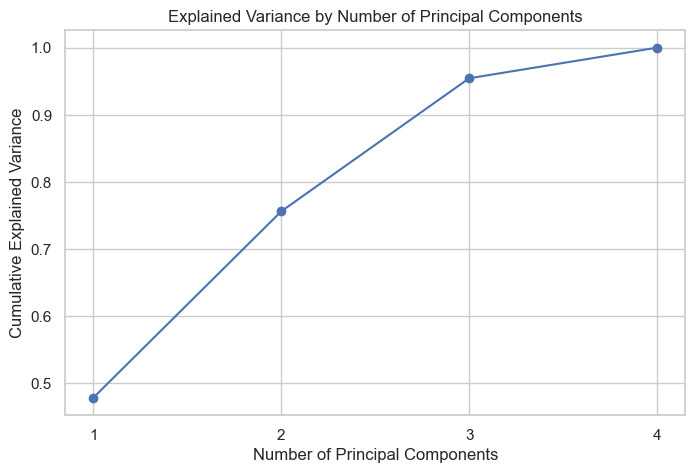

In [10]:
# Apply PCA
pca = PCA(n_components=None)
pca.fit(baseline_df)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

#### Assert number of PCs = 3

In [11]:
pca = PCA(n_components=3)
baseline_pca = pca.fit_transform(baseline_df)

In [12]:
baseline_pca[:3]

array([[ 1.32893466,  0.55019907,  1.14143053],
       [ 0.66922411, -0.39082384, -0.21507419],
       [ 2.98981488, -1.95142108, -0.80508727]])

#### Compute ideal number of clusters using elbow method

In [14]:
# Repeating the elbow method for KMeans clustering with the PCA transformed data
inertia = []
silhouette_scores = []
K_range = range(2, 11)  # Testing for k=2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(baseline_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(baseline_pca, kmeans.labels_))

# Plotting the Elbow Method Graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)

# Plotting Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores For Different k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

/Users/timbeckerhomefolder/opt/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

#### Perform clustering: PLEASE ADJUST N CLUSTERS VAR BASED ON GRAPH ABOVE

In [ ]:
n_clusters = 4
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model.fit(baseline_pca)
k_means_cluster_labels = kmeans_model.labels_

#### Results: Visualize clusters in space along three PCs

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
ax.scatter(baseline_pca[:, 0], baseline_pca[:, 1], baseline_pca[:, 2], c=cluster_labels, cmap='viridis', marker='o')

# Labeling the axes
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Visualization of Clusters')

# Show plot
plt.show()

#### Append cluster labels to initial dataframe

In [ ]:
df["Cluster"] = k_means_cluster_labels

#### Extrinsic evaluation

In [ ]:
create_stacked_bar_plot(df, "category_name", "Cluster", "K-Means Clustering")

In [ ]:
create_stacked_bar_plot(df, "condition_name", "Cluster", "K-Means Clustering")

In [ ]:
create_cluster_boxplots(df, "Cluster", "K-Means Clustering")

#### Intrinsic evaluation: WCSS

In [ ]:
wcss = kmeans_model.inertia_
print(wcss)

# Centroid-based: K-Prototypes

In [31]:
# Reset dataset, used during modelling and overwrites any previous changes
data.reset_dataset()

# Extract the dataframe
df = data.df.copy()

# Filter out rare subsubsub categories and ordinally encode conditions
df = filter_rare_categories(df, 'subsubsubcategory_name', 'subsubcategory_name')
df = condition_encoding(df)

# Subtracting brands with less than 30 listings
brands = df['brand_name'].value_counts()
brands = brands[brands < 30].index

df.loc[df[df.brand_name.isin(brands)].index, 'brand_name'] = 'Other'    

# Extracting relevant columns for clustering
cluster_data = df[['brand_name','subsubsubcategory_name','listing_price','viewed_count', 'condition_name']]

# Numeric Columns
num_col = (cluster_data.select_dtypes('integer') +
           cluster_data.select_dtypes('float')).columns.to_list()

cluster_data_norm = cluster_data.copy()

cluster_data_norm.loc[:, num_col] = StandardScaler().fit_transform(cluster_data[num_col])

In [32]:
# Initalize models
model = KPrototypes(n_clusters=4, init='Cao', n_jobs=-1) 

# Fit and predict clusters for data
clusters = model.fit_predict(cluster_data_norm.to_numpy(), categorical=[0,1])

KeyboardInterrupt: 

In [13]:
# Add clusters to dataframe
df['cluster'] = clusters
cluster_data['cluster'] = clusters

/var/folders/_5/m8cq6l8x4nqg0f7r8lv9pw9w0000gn/T/ipykernel_8542/3082798370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['cluster'] = clusters


In [26]:
df.head(2)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,...,subsubsubcategory_name,classified_price_standardized,viewed_count_standardized,favourites_standardized,classified_price_normalized,viewed_count_normalized,favourites_normalized,log_listing_price,log_viewed_count,cluster
0,30343099,2023-09-06,2425635,900,1299,10,145,Air Jordan,3,Black,...,Sneakers,0.933785,0.706555,0.183100,0.118236,0.013349,0.032573,7.170120,4.983607,2
1,30346312,2023-09-06,144602,225,350,12,119,Ganni,3,Multi,...,Skirts,-0.370245,0.459288,0.362075,0.028056,0.010956,0.039088,5.860786,4.787492,1


In [52]:
# Evaluate clusters
grouped_df = df.groupby('cluster').agg(
    mean_listing_price = ('listing_price', 'mean'),
    mean_views = ('viewed_count', 'mean'),
    top_5_brands = ('brand_name', lambda x: x.value_counts().index[0:5]),
    sub_categories = ('subsubcategory_name', lambda x: x.value_counts().index[0:5]),
    subsub_cateogries = ('subsubsubcategory_name', lambda x: x.value_counts().index[0:5]),
    count = ('classified_id', 'count'))

grouped_df["share"] = grouped_df["count"] / len(df)

grouped_df

,mean_listing_price,mean_views,top_5_brands,sub_categories,subsub_cateogries,count,share
cluster,,,,,,,
0,442.001672,44.158577,"[Adidas, Zara, UGG, Stussy, Nike]","[Clothes, Women, Men, Accessories, Home]","[Sneakers, T-shirts, Trousers, Dresses, Tops]",75957,0.268347
1,296.584705,45.149059,"[Carhartt, Nike, Zara, Ganni, One Vintage]","[Clothes, Women, Men, Home, Accessories]","[Trousers, Sneakers, Jeans, Jackets, T-shirts]",171254,0.605020
2,675.608636,263.055560,"[Stone Island, Carhartt, Stussy, Planet Nusa, ...","[Clothes, Women, Men, Accessories, Sportswear]","[Jackets, Knitwear, Trousers, Sneakers, T-shirts]",25360,0.089594
3,2377.589470,99.121328,"[Polo Ralph Lauren, Moncler, Louis Vuitton, Ai...","[Clothes, Women, Men, Electronics, Smartphones...","[Jackets, Sneakers, Shirts, Shoulder bags, Cro...",10484,0.037039


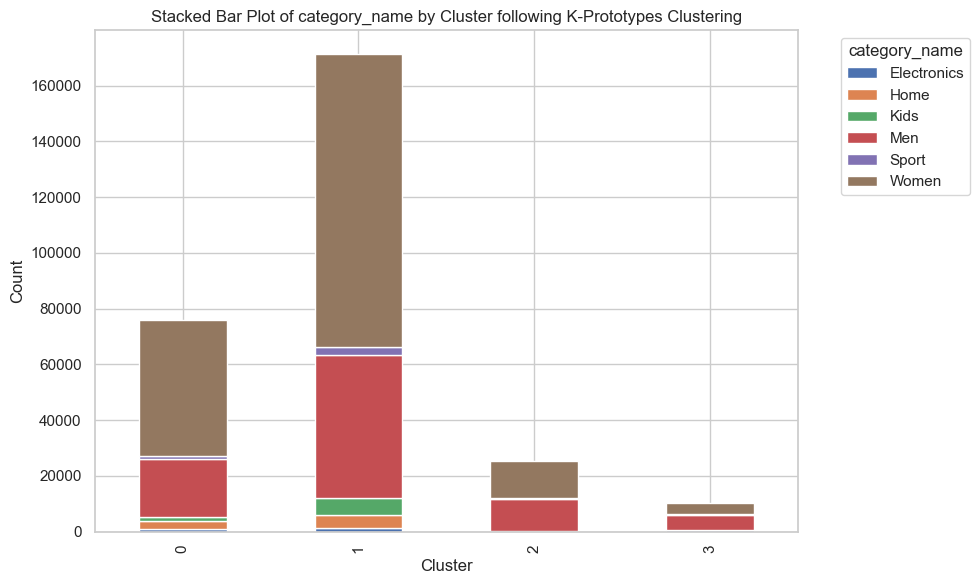

In [39]:
create_stacked_bar_plot(df, "category_name", "cluster", "K-Prototypes Clustering")

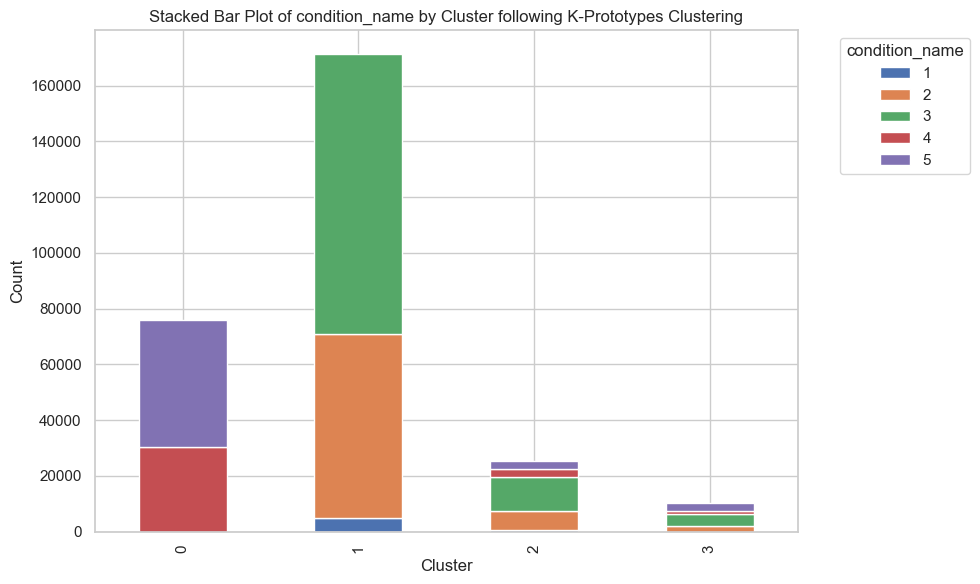

In [41]:
create_stacked_bar_plot(df, "condition_name", "cluster", "K-Prototypes Clustering")

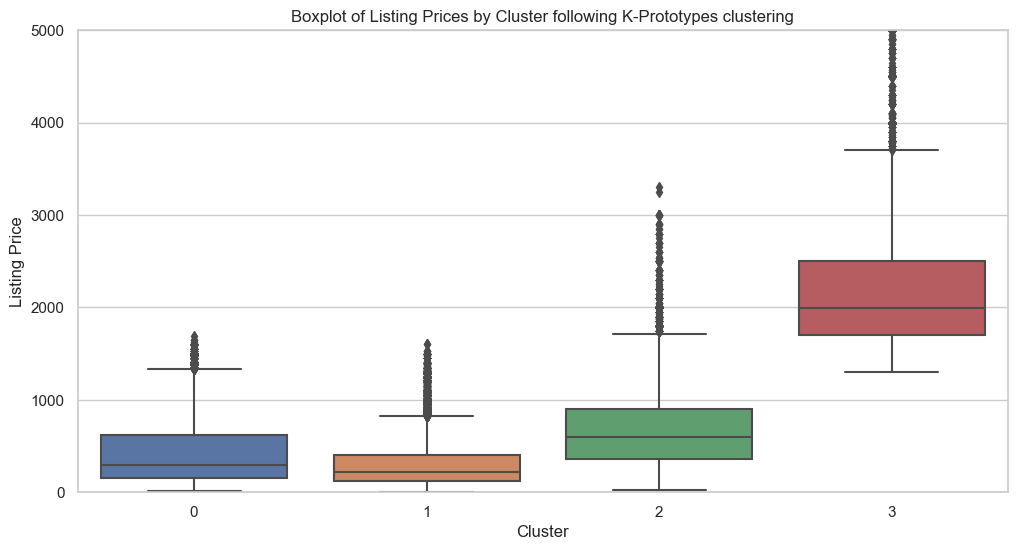

In [49]:
create_cluster_boxplots(df, "cluster", "K-Prototypes clustering")

## Visualisation of clusters in best performing model

KeyError: 'Cluster'

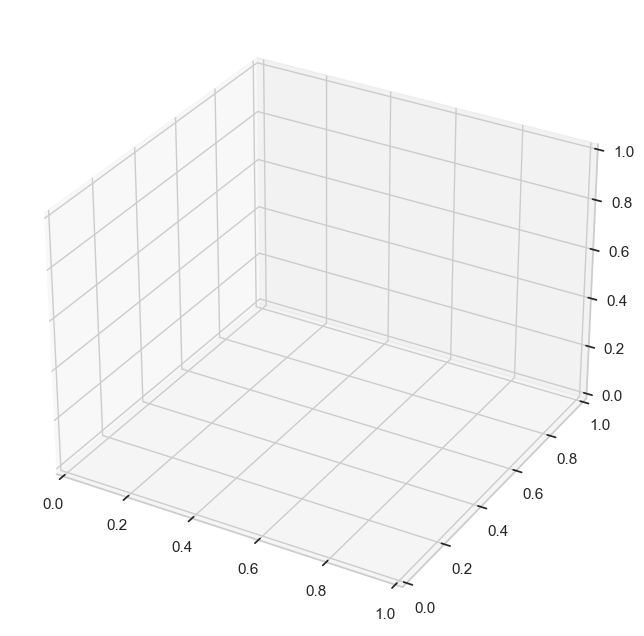

In [14]:
# Let's choose the first three numeric columns for this purpose
subset_df = clustering_df[['log_listing_price_normalized', 'brand_name_normalized', 'condition_name_normalized']]

# Visualizing the specified clustering in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three dimensions and coloring by cluster
scatter = ax.scatter(subset_df['log_listing_price_normalized'], subset_df['brand_name_normalized'], subset_df['condition_name_normalized'], 
                     c=clustering_df['Cluster'], cmap='viridis', marker='o', alpha=0.1)

# Adding labels and title
ax.set_xlabel('Log Listing Price')
ax.set_ylabel('Encoded Brand')
ax.set_zlabel('Encoded Condition')
ax.set_title('3D Visualization of Clustering')

# Adding a legend for clusters
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

# Repo for clustering attempts with other models

## Density-based: DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [17]:
dbscan_subset = baseline_df[:100000]

In [20]:
dbscan = DBSCAN(eps=2, min_samples=10)
clusters = dbscan.fit_predict(dbscan_subset)

# Add the cluster labels to your DataFrame
dbscan_subset['Cluster'] = clusters

In [19]:
# how many clusters are there
dbscan_subset.Cluster.nunique()

56

In [ ]:
# 0.5 and 5 yield 56 clusters

In [28]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
clusters = dbscan.fit_predict(subset)

# Add the cluster labels to your DataFrame
subset['Cluster'] = clusters

# Check the first few rows
print(subset.head())

   listing_price  viewed_count_normalized  favourites_normalized  \
0       0.097697                 0.013349               0.032573   
1       0.026048                 0.010956               0.039088   
2       0.008683                 0.019241               0.123779   
3       0.033598                 0.003775               0.016287   
4       0.044923                 0.019149               0.045603   

   condition_name  Cluster  
0            0.50        0  
1            0.50        0  
2            0.25        1  
3            1.00        2  
4            0.75        3  


/var/folders/_5/m8cq6l8x4nqg0f7r8lv9pw9w0000gn/T/ipykernel_5957/3936805235.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster'] = clusters


In [29]:
# how many clusters are there
subset.Cluster.unique()

array([ 0,  1,  2,  3,  4, -1])

In [36]:
len(subset)

100000

#### Visualise

In [30]:
dbscan_analysis = df[:100000]
dbscan_analysis["Cluster"] = clusters

/var/folders/_5/m8cq6l8x4nqg0f7r8lv9pw9w0000gn/T/ipykernel_6736/2735824059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbscan_analysis["Cluster"] = clusters


In [37]:
# Evaluate clusters
grouped_df = dbscan_analysis.groupby('Cluster').agg(
    mean_listing_price = ('listing_price', 'mean'),
    mean_views = ('viewed_count', 'mean'),
    top_5_brands = ('brand_name', lambda x: x.value_counts().index[0:5]),
    sub_categories = ('subsubcategory_name', lambda x: x.value_counts().index[0:5]),
    subsub_cateogries = ('subsubsubcategory_name', lambda x: x.value_counts().index[0:5]),
    count = ('classified_id', 'count'))

grouped_df["share"] = grouped_df["count"] / len(df)

grouped_df

,mean_listing_price,mean_views,top_5_brands,sub_categories,subsub_cateogries,count,share
Cluster,,,,,,,
-1,8187.857143,232.500000,"[Jordan, Saks Potts, Louis Vuitton, Adidas, Ch...","[Men, Women, Clothes]","[Men, Sneakers, Crossbody bags, Shoulder bags,...",14,0.000049
0,476.254289,73.710070,"[Ganni, One Vintage, Mads Nørgaard, The North ...","[Clothes, Women, Men, Accessories, Til drenge]","[Dresses, Sneakers, Jackets, Shirts, Knitwear]",43545,0.153839
1,412.695702,74.415790,"[One Vintage, Ganni, The North Face, Levi's, M...","[Clothes, Women, Men, Accessories, Til drenge]","[Sneakers, Jackets, Jeans, Knitwear, Trousers]",26244,0.092717
2,762.097155,65.419561,"[Adidas, UGG, Ralph Lauren, Ganni, Corteiz]","[Women, Clothes, Men, Accessories, Skin care]","[Sneakers, Flats, T-shirts, Dresses, Boots]",16870,0.059600
3,472.640607,71.349687,"[Ganni, Mads Nørgaard, One Vintage, Maanesten,...","[Clothes, Women, Men, Accessories, Sportswear]","[Dresses, Trousers, T-shirts, Shirts, Knitwear]",11333,0.040038
4,350.600802,77.027583,"[New Balance, Ganni, Air Jordan, One Vintage, ...","[Clothes, Women, Men, Accessories, Smartphones...","[Sneakers, Jackets, Jeans, T-shirts, Boots]",1994,0.007045


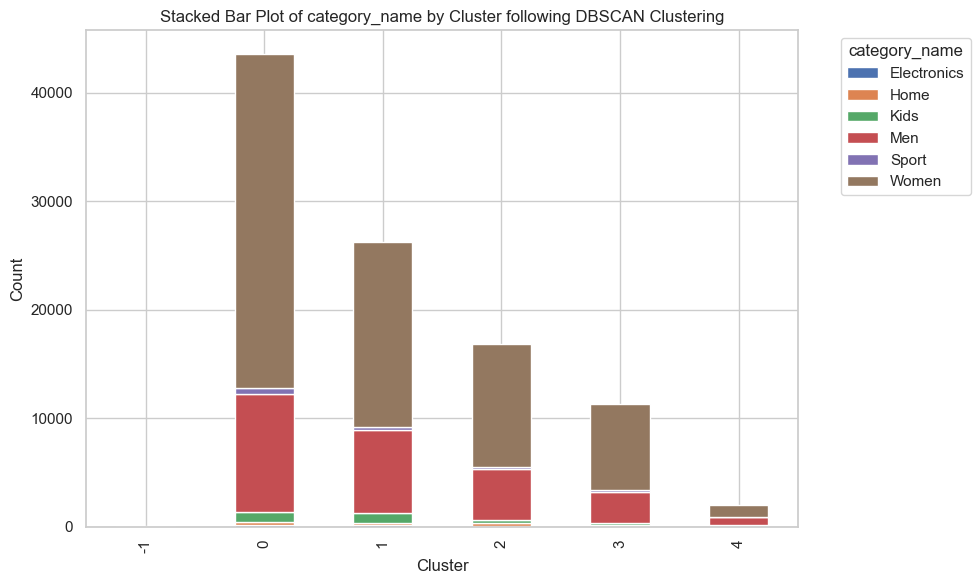

In [38]:
create_stacked_bar_plot(dbscan_analysis, "category_name", "Cluster", "DBSCAN Clustering")

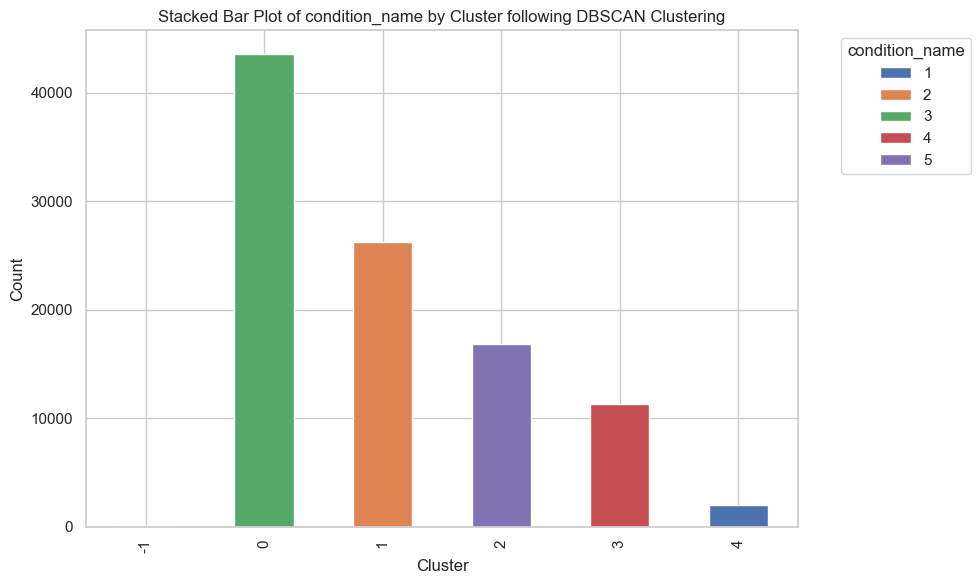

In [39]:
create_stacked_bar_plot(dbscan_analysis, "condition_name", "Cluster", "DBSCAN Clustering")

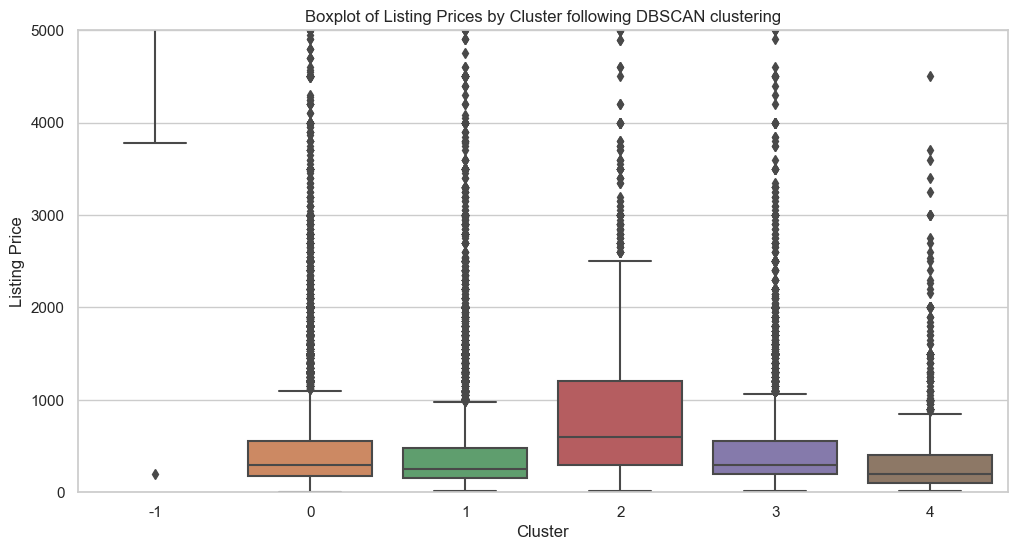

In [40]:
create_cluster_boxplots(dbscan_analysis, "Cluster", "DBSCAN clustering")

## Hierarchical-based: BIRCH

In [ ]:
# Reset dataset, used during modelling and overwrites any previous changes
data.reset_dataset()

# Extract the dataframe
df = data.df.copy()

In [16]:
from sklearn.cluster import Birch, AgglomerativeClustering

#### v1 on small dataset

In [50]:
len(cluster_data)

283055

In [41]:
cluster_data.columns

Index(['listing_price', 'viewed_count_normalized', 'favourites_normalized',
       'condition_name'],
      dtype='object')

In [59]:
birch_model = Birch(threshold=0.05, branching_factor=5)

# Fit the model and predict clusters
cluster_labels = birch_model.fit_predict(cluster_data)

# Add the cluster labels to your DataFrame
cluster_data['Cluster'] = cluster_labels

# Display the first few rows of the DataFrame with cluster labels
print(cluster_data.head())

   listing_price  viewed_count_normalized  favourites_normalized  \
0       0.097697                 0.013349               0.032573   
1       0.026048                 0.010956               0.039088   
2       0.008683                 0.019241               0.123779   
3       0.033598                 0.003775               0.016287   
4       0.044923                 0.019149               0.045603   

   condition_name  Cluster  
0            0.50        1  
1            0.50        1  
2            0.25        1  
3            1.00        2  
4            0.75        2  


/var/folders/_5/m8cq6l8x4nqg0f7r8lv9pw9w0000gn/T/ipykernel_5957/311736390.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Cluster'] = cluster_labels


In [57]:
cluster_data['Cluster'].nunique()

3

In [63]:
birch_analysis = df.copy()

birch_analysis["Cluster"] = cluster_data['Cluster']

In [64]:
# Evaluate clusters
grouped_df = birch_analysis.groupby('Cluster').agg(
    mean_listing_price = ('listing_price', 'mean'),
    mean_views = ('viewed_count', 'mean'),
    top_5_brands = ('brand_name', lambda x: x.value_counts().index[0:5]),
    sub_categories = ('subsubcategory_name', lambda x: x.value_counts().index[0:5]),
    subsub_cateogries = ('subsubsubcategory_name', lambda x: x.value_counts().index[0:5]),
    count = ('classified_id', 'count'))

grouped_df["share"] = grouped_df["count"] / len(df)

grouped_df

,mean_listing_price,mean_views,top_5_brands,sub_categories,subsub_cateogries,count,share
Cluster,,,,,,,
0,3768.340237,146.209467,"[Moncler, Louis Vuitton, Prada, Stone Island, ...","[Clothes, Women, Men, Electronics, Smartphones...","[Jackets, Sneakers, Crossbody bags, Shoulder b...",1690,0.005971
1,377.366938,67.907973,"[Carhartt, Nike, Zara, Ganni, One Vintage]","[Clothes, Women, Men, Accessories, Home]","[Trousers, Jackets, Sneakers, Jeans, Knitwear]",195736,0.691512
2,539.440271,61.395765,"[Adidas, Stussy, UGG, Zara, Nike]","[Clothes, Women, Men, Accessories, Home]","[Sneakers, T-shirts, Trousers, Jackets, Dresses]",85629,0.302517


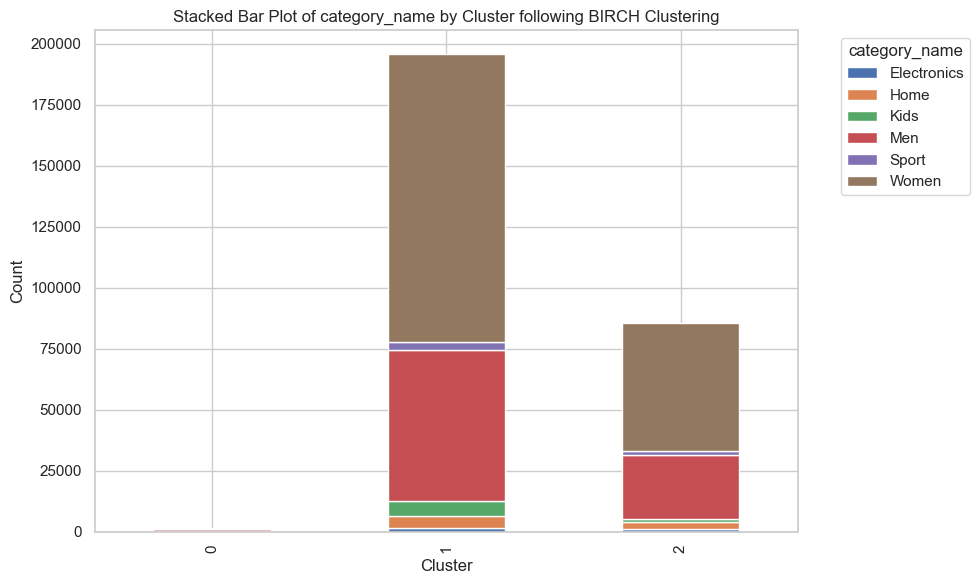

In [66]:
create_stacked_bar_plot(birch_analysis, "category_name", "Cluster", "BIRCH Clustering")

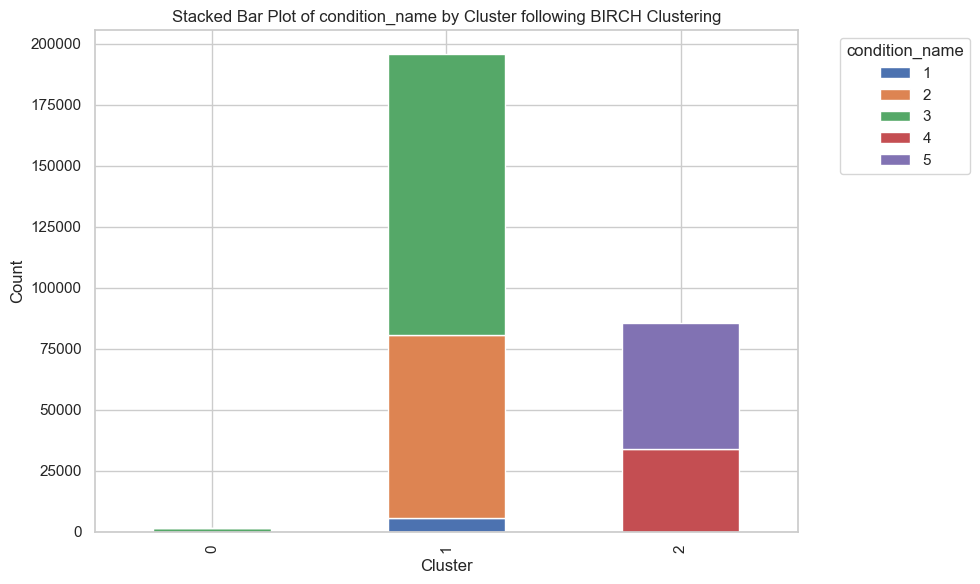

In [67]:
create_stacked_bar_plot(birch_analysis, "condition_name", "Cluster", "BIRCH Clustering")

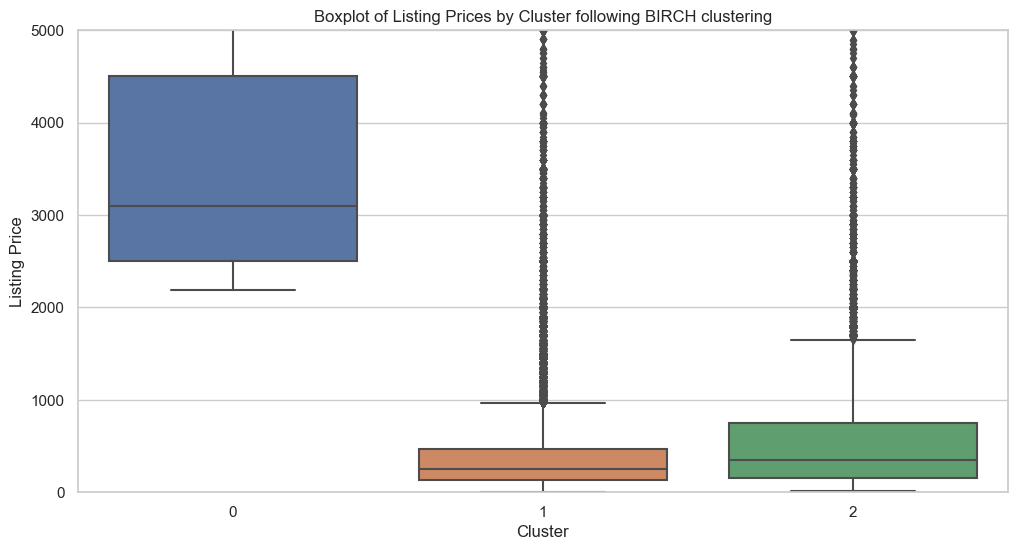

In [68]:
create_cluster_boxplots(birch_analysis, "Cluster", "BIRCH clustering")